# XRD Final Code
## Jamie DeCoster 112020536

In [1]:
def XRD_import(myfilename):
    """This function opens a .csv file and reads the XRD data within and stores it
    as numpy arrays.(Shifting the data so all intensities are positive.) It also 
    saves a plot of the data.
    Inputs:
    myfilename: .csv file of XRD data (2theta in column 1, intensity in column 2)
    
    Outputs:
    x: 2theta data
    y: intensity data"""
    
    #Import the data using pandas
    df=pd.read_csv(myfilename)
    
    #Store the names of the columns to be used for indexing
    col_name=df.columns
    
    #We want the data to all have a positive intensity before finding the maximum
    #First store the data as numpy arrays
    x=np.array(df[col_name[0]])
    y=np.array(df[col_name[1]])

    #Find the minimum value
    min_y=np.argmin(y)

    #If it is negative then we have to shift the curve to the positive intensities
    if y[min_y]<0:
        y=y+abs(y[min_y])
        
        
    #Plot all of the data
    plt.figure(figsize=(8,5),dpi=300,facecolor='white')
    plt.plot(x,y,'r')
    plt.xlabel('2θ (degrees)')
    plt.ylabel("Intensity (a.u.)")
    plt.title("XRD Spectra")
    plt.savefig("XRD_Spectra.png",dpi=300)
    plt.show()

    return x,y

In [2]:
def XRD_slice(x,y,theta_111,range1,save=False):
    """This function examines the XRD data, stores only the data around the peak of interest, and plots the result. 
    Inputs:
    x: 2theta values
    y: intensity
    theta_111: peak of interest
    range1: the amount around the peak that should be examined (location of the peak + and - this value)
    save: allows you to toggle whether to save the figure or not (True=save, False=does not save)
    
    Outputs:
    x2: 2theta data of the sliced peak
    y2: intensity data of the sliced peak"""
    
    #We want to splice the data so we are just examining the 111 peak
    #Preallocate the lists
    x2=[]
    y2=[]

    #Move through all the data
    for i in range(len(x)):
        #If the data is between range1 above and range1 below the 111 peak, we store the data in a new list
        if x[i]>(theta_111-range1) and x[i]<(theta_111+range1):
            x2.append(x[i])
            y2.append(y[i])
    
    #Save as a numpy array
    x2=np.array(x2)
    y2=np.array(y2)
    
    #Plot the peak
    plt.figure(figsize=(8,5),dpi=300,facecolor='white')
    plt.plot(x2,y2,'b*',label='Experimental')
    plt.xlabel('2θ (degrees)')
    plt.ylabel("Intensity (a.u.)")
    plt.title("(111) XRD Peak of Sample")
    
    #If the save variable is set to true then save the figure
    if save: 
        plt.savefig("(111) XRD Peak of Sample")
        
    #Show the plot
    plt.show()
    
    return x2,y2

In [3]:
def XRD_FWHM(x2,y2):
    """This function calculates the full width half max of an XRD peak and returns the Bragg angle of the peak and the FWHM.
    inputs:
    x2: 2theta data surrounding the peak of interest
    y2: intensity data surrounding the peak of interest
    
    outputs:
    FWHM_rad: full-width half max of the peak in radians
    theta_rad: Bragg angle of the peak in radians"""
    
    #Create a Gaussian function 
    def gauss(x,H,a,b,c):
        return H+a*np.exp(-(x-b)**2/(2*c**2))
    
    #Then fit the data to the Gaussian function 
    a,b=scipy.optimize.curve_fit(gauss,x2,y2)
    
    #Determine the R^2 value 
    res=y2-gauss(x2,*a)
    SSE=sum((res)**2)
    SST=sum((y2-np.mean(y2))**2)
    R_square=1.0-(SSE/SST)
    
    #Plot the experimental data
    plt.figure(figsize=(8,5),dpi=300,facecolor='white')
    plt.plot(x2,y2,'b*',label='Experimental')
    plt.xlabel('2θ (degrees)')
    plt.ylabel("Intensity (a.u.)")
    plt.title("(111) XRD Peak of Sample")    
    
    #Plot the fit
    x3=np.linspace(x2[0],x2[len(x2)-1],400)
    y3=gauss(x3,*a)
    plt.plot(x3,y3,'r-',label="Gauss")
    plt.legend()
    
    #Determine the RMS
    rms=np.sqrt(sum((pow((np.array(gauss(x2,*a))-y2),2)))/len(y2))
    
    #Add the equation and R^2 value to the plot
    plt.text(min(x2),0.5*max(y2),'$R^2$ = {:.4f}\nRMS = {:.4f}'.format(R_square,rms),fontsize=14, bbox=dict(facecolor='grey',alpha=0.2))
    
    #Save the figure
    plt.savefig("XRD_111_Fit.png",dpi=300)
    plt.show()
    
    #Find the index of the maximum of the peak
    ind_max=np.argmax(y3)

    #Store the theta of the peak (2theta/2) and convert it to radians
    theta_deg=x3[ind_max]/2
    theta_rad=np.radians(theta_deg)

    #Find the half of the maximum height
    half_max=0.5*y3[ind_max]

    #Find the full width of half of the maximum height
    #Preallocate the first x location
    x_width1=0

    #From the location of the maximum height, iterate in the -x direction to find the half max
    for i in range(ind_max,-1,-1):
        #if the half max height is between the current location and the previous location, 
        #use interpolation between those two points to find the exact 2theta of the half max
        if y3[i]>half_max and y3[i-1]<half_max:
            x1_interp=scipy.interpolate.interp1d(y3[i-1:i+1],x3[i-1:i+1],kind="linear")
            x_width1=x1_interp(half_max)

    #Preallocate the second x-location
    x_width2=0

    #From the location of the maximum height, iterate through the data in the +x direction to find the half maximum
    for i in range(ind_max,len(y3)-1):
        #if the half max height is between the current location and the next location, 
        #use interpolation between those two points to find the exact 2theta of the half max
        if y3[i]>half_max and y3[i+1]<half_max:
            x2_interp=scipy.interpolate.interp1d(y3[i:i+2],x3[i:i+2],kind="linear")
            x_width2=x2_interp(half_max)
            
    #Determine the FWHM and then convert it into radians
    FWHM_deg=x_width2-x_width1
    FWHM_rad=np.radians(FWHM_deg)

    return FWHM_rad, theta_rad

In [4]:
def Scherrer(FWHM,theta,k=0.9,lam=0.016635):
    """This function calculates the crystallite size using the Scherrer equation
    inputs: 
    FWHM: full width half max of the 111 peak in radians
    theta: Bragg angle of the peak in radians
    k: shape factor
    lam: wavelength of the x-ray beam
    
    output:
    crystallite size
    """
    
    return ((k*lam)/(FWHM*np.cos(theta)))

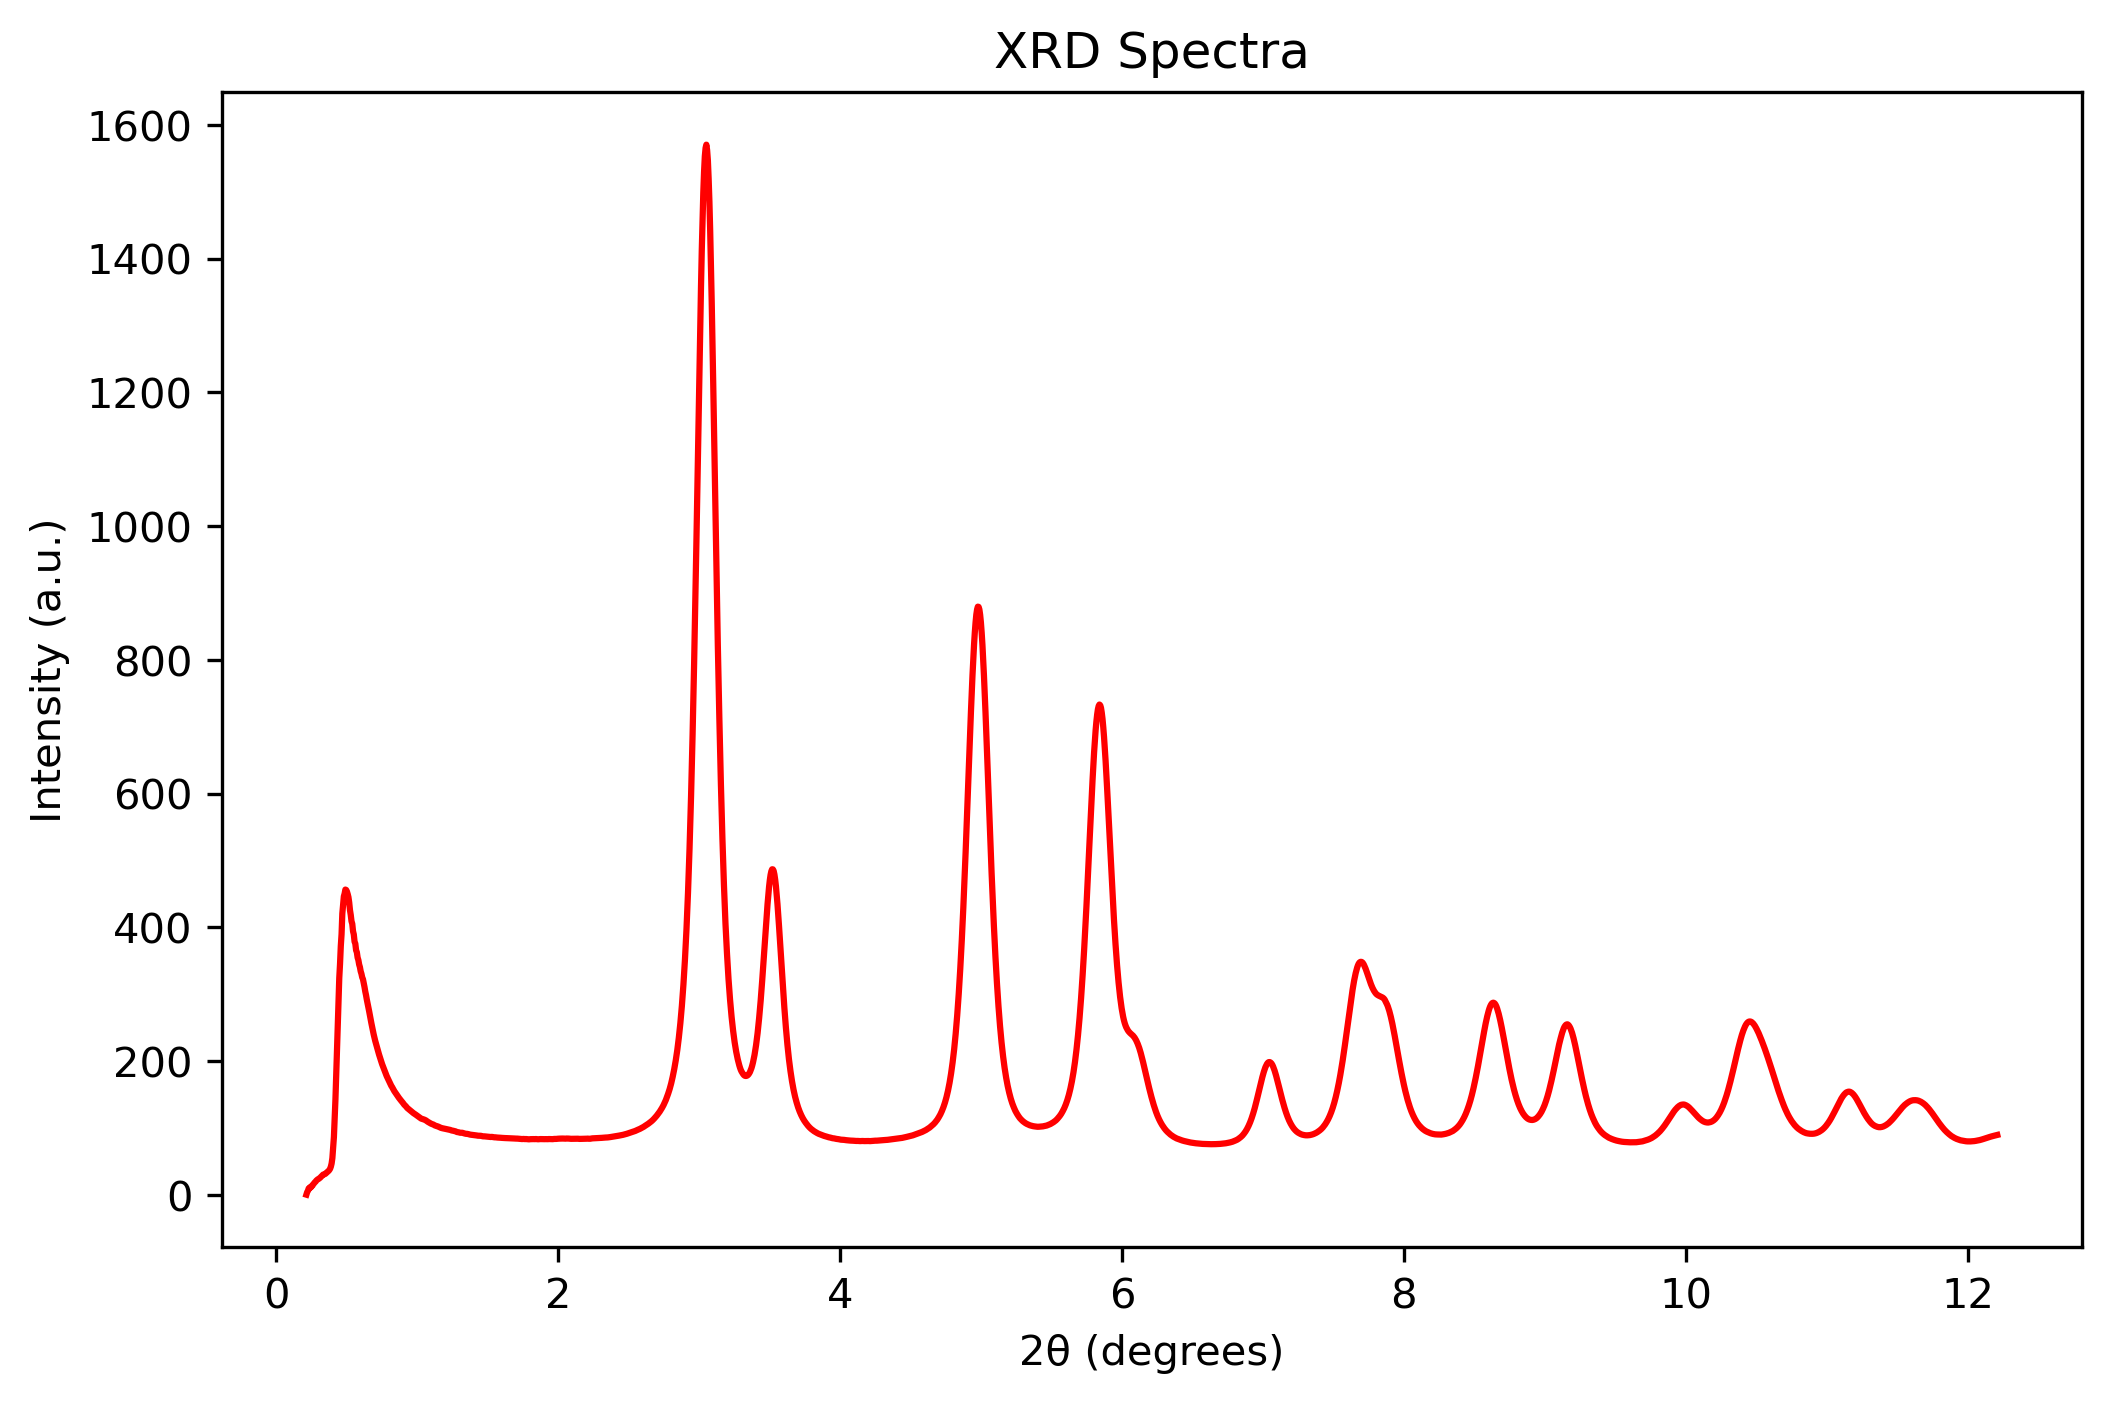

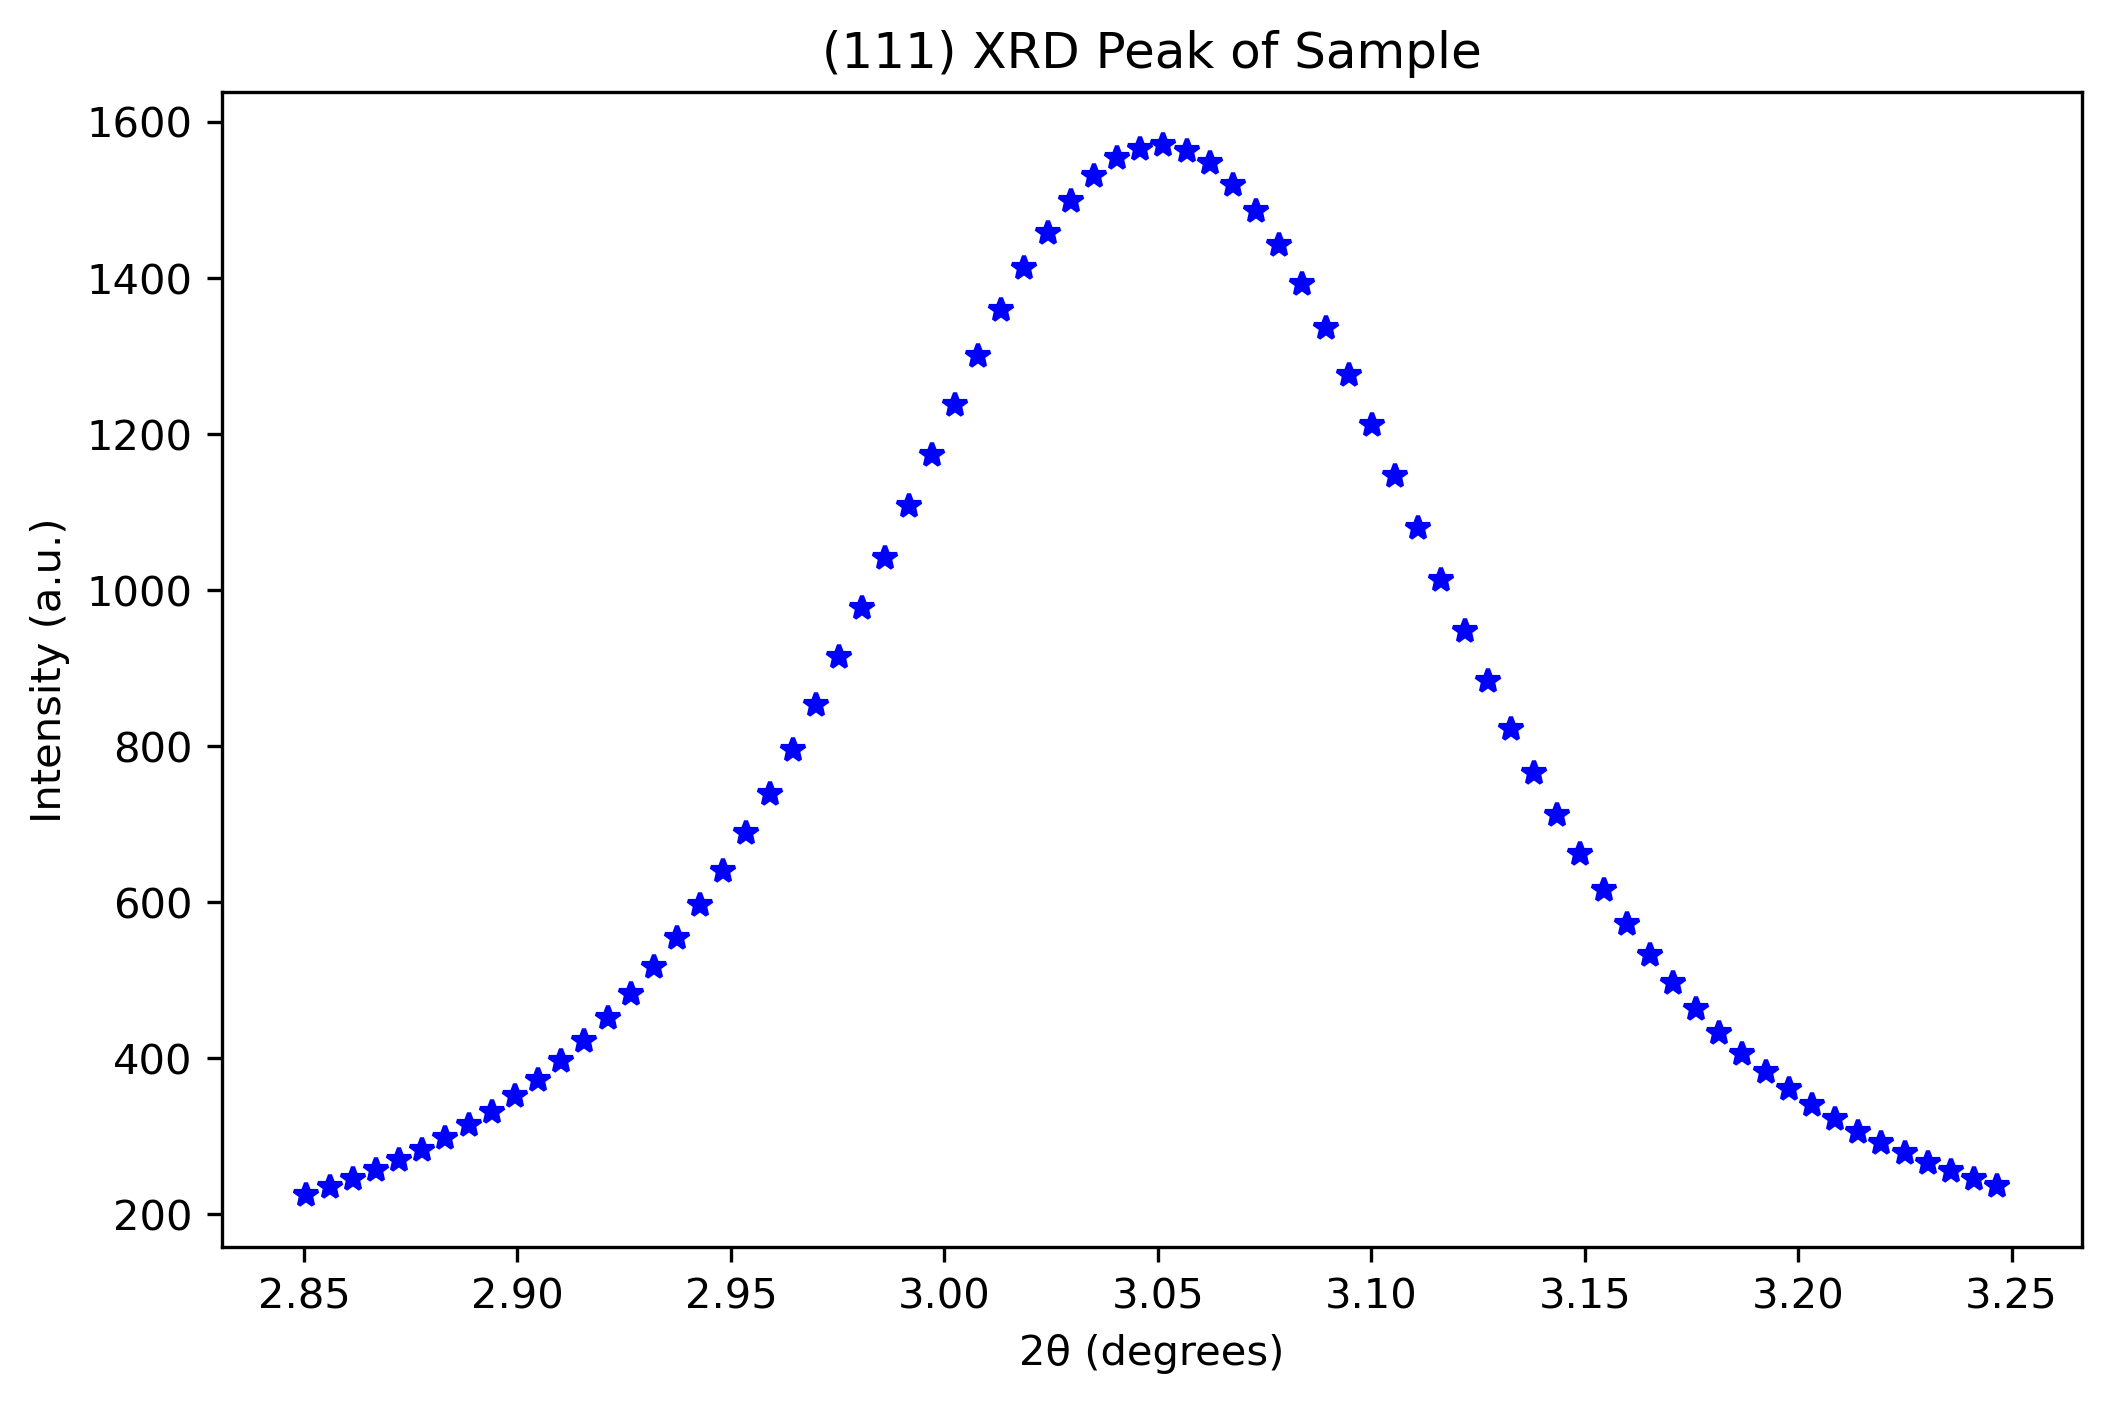

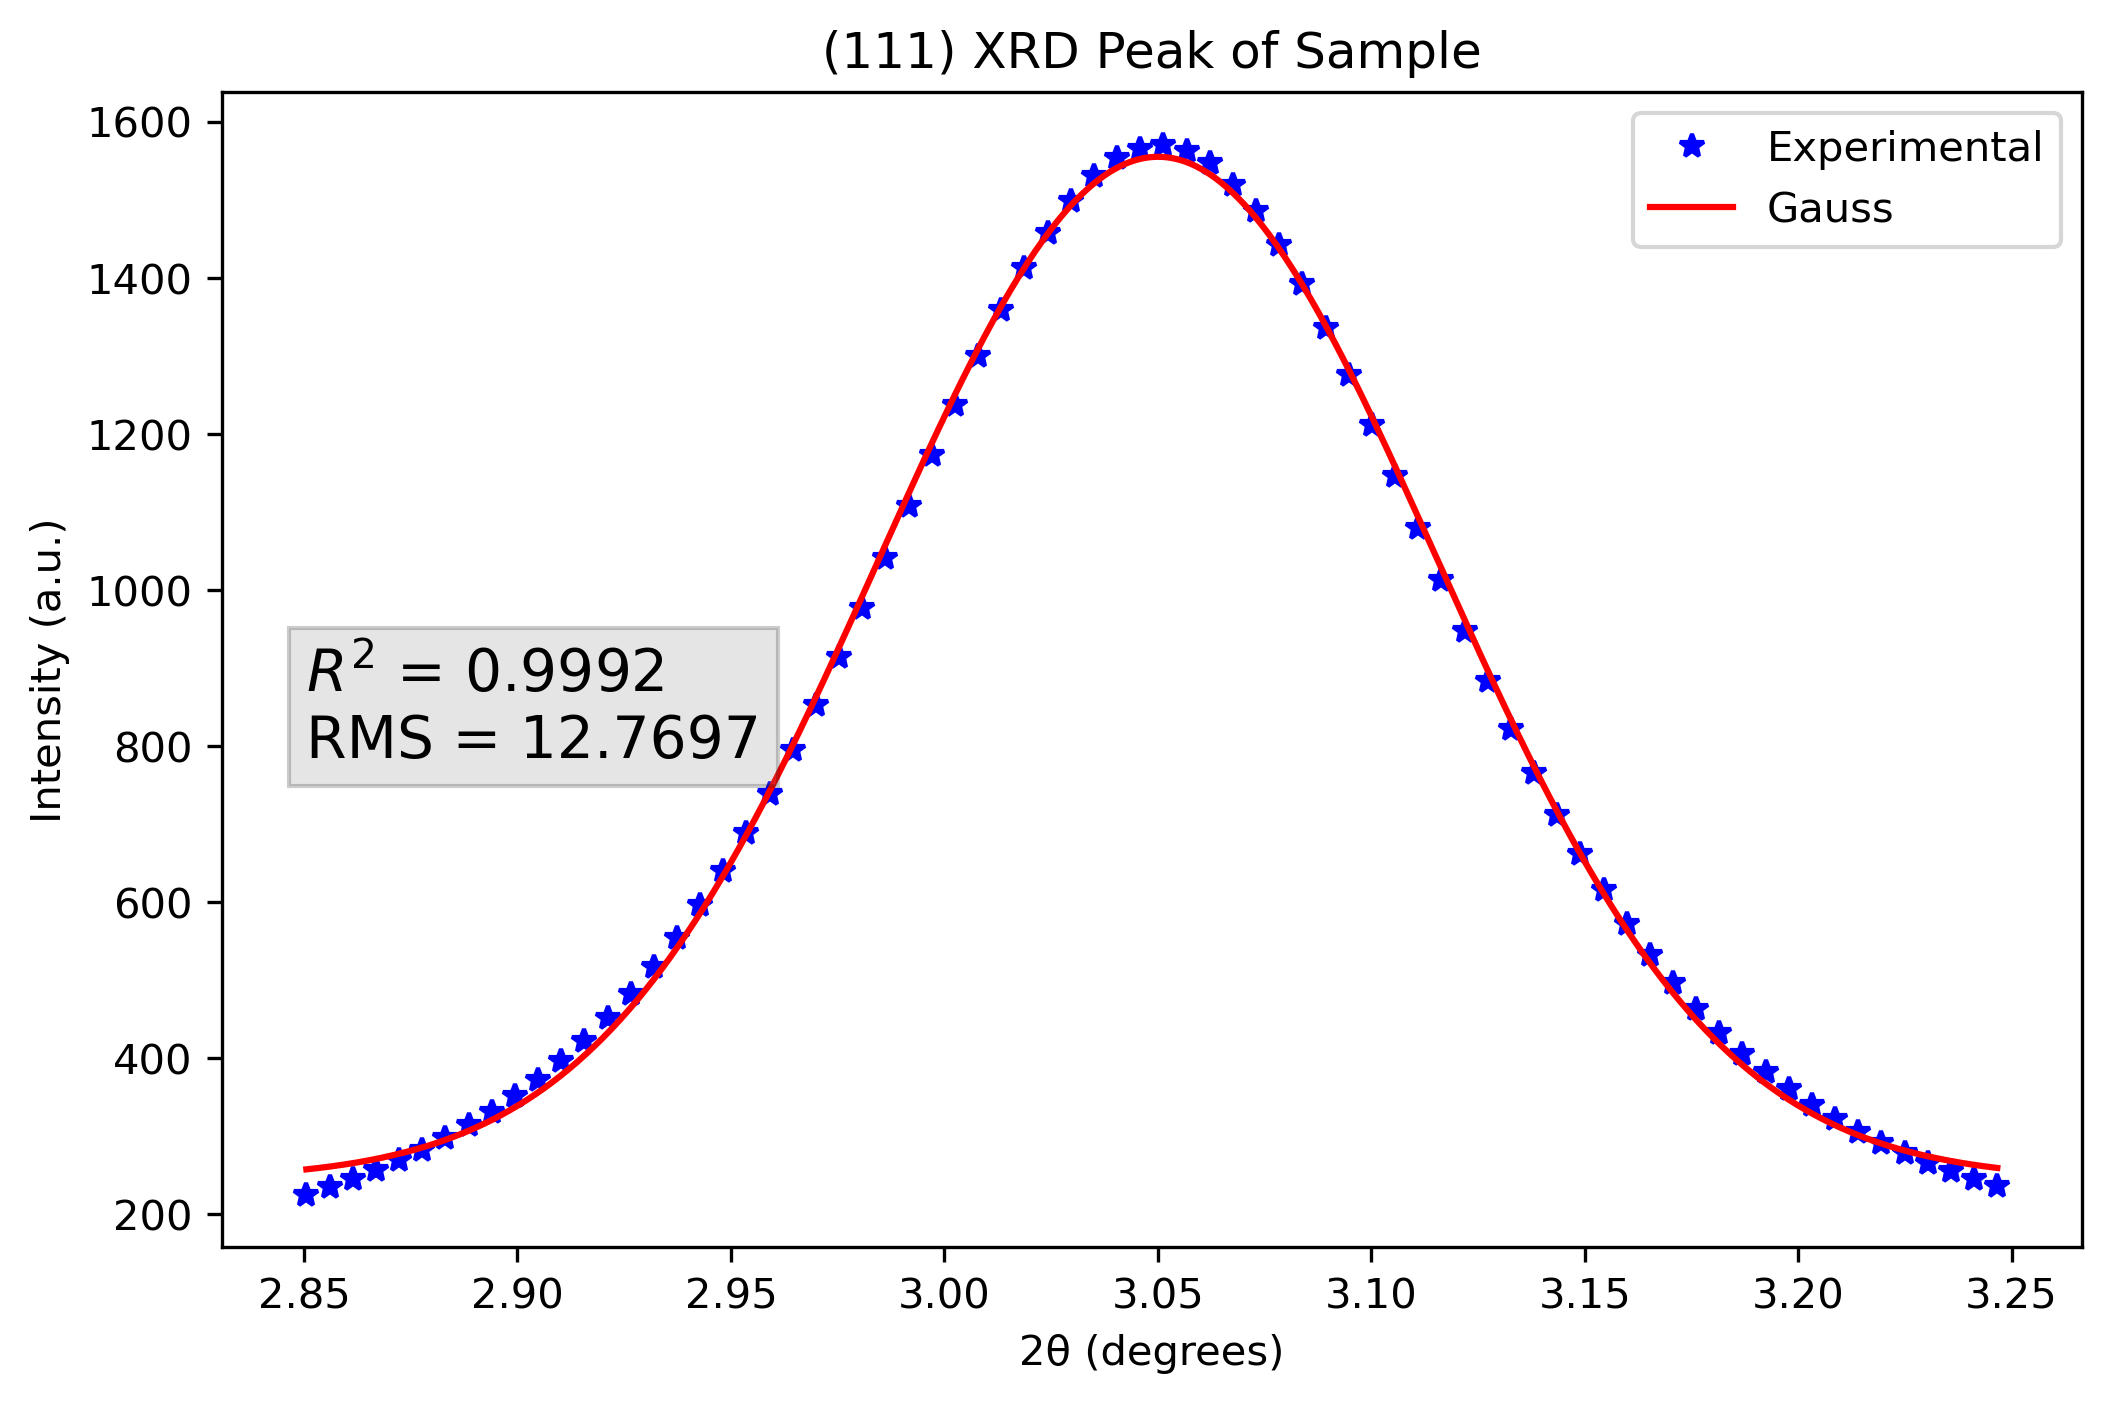

Crystallite size: 4.89


In [5]:
#This script calls the four functions that are previously used to then determine crystallite size. 

#Import the necessary packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import scipy.interpolate

#First call the first function to import the data and create an XRD plot
x,y=XRD_import("XRD 500C-Jamie DeCoster.csv")

#Then call the slice function to store the data of the peak of interest (111 peak)
x2,y2=XRD_slice(x,y,3.05,0.2,save=True)

#Then call the FWHM function to determine the FWHM and the theta of the maximum
FWHM_1,theta_1=XRD_FWHM(x2,y2)

#Then call the last function to determine the crystallite size
crystallite_size1=Scherrer(FWHM_1,theta_1)

#Then display the result
print("Crystallite size: {:.2f}".format(crystallite_size1))